In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"]="0"
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt

from config import Config
import utils
import model as modellib
import visualize
from model import log
from bowl_data_set import BowlDataset
import pandas as pd

%matplotlib inline 

# Root directory of the project
ROOT_DIR = os.getcwd()

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

# Local path to trained weights file
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")
# Download COCO trained weights from Releases if needed
if not os.path.exists(COCO_MODEL_PATH):
    utils.download_trained_weights(COCO_MODEL_PATH)

/home/hyperminer02/anaconda3/envs/py36/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
from bowl_config import BowlConfig

config = BowlConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_SHAPES                [[64 64]
 [32 32]
 [16 16]
 [ 8  8]
 [ 4  4]]
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     16
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
DETECTION_MAX_INSTANCES        500
DETECTION_MIN_CONFIDENCE       0.7
DETECTION_NMS_THRESHOLD        0.3
GPU_COUNT                      1
IMAGES_PER_GPU                 16
IMAGE_MAX_DIM                  256
IMAGE_MIN_DIM                  224
IMAGE_PADDING                  True
IMAGE_SHAPE                    [256 256   3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
MASK_POOL_SIZE                 14
MASK_SHAPE                     [28, 28]
MAX_GT_INSTANCES               400
MEAN_PIXEL                     [43.5 39.6 48.2]
MINI_MASK_SHAPE                (56, 56)
NAME                           Bowl
NUM_CLASSES                    2
POOL_SIZE                      7
POST_NMS_ROIS_INFERENCE        1000
PO

In [7]:
def get_ax(rows=1, cols=1, size=8):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Change the default size attribute to control the size
    of rendered images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

In [8]:
dataset_dir = "stage1_train"
augment_dir = "stage1_augment_train"
num_per_image = 3

img_ids = next(os.walk(dataset_dir))[1]
# x is your dataset
np.random.seed(0)
np.random.shuffle(img_ids)
train_len = int(len(img_ids) * 0.75)
train_img_ids, val_img_ids = img_ids[:train_len], img_ids[train_len:]

# Training dataset
dataset_train = BowlDataset()
dataset_train.load_bowl(dataset_dir, train_img_ids)
dataset_train.augment(augment_dir, num_per_image)
dataset_train.prepare()

# Validation dataset
dataset_val = BowlDataset()
dataset_val.load_bowl(dataset_dir, val_img_ids)
dataset_val.prepare()

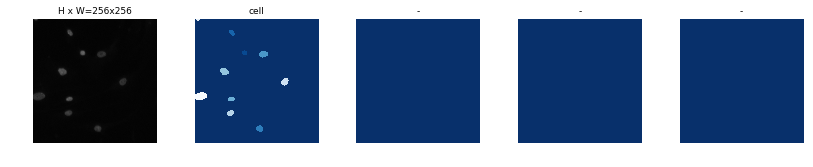

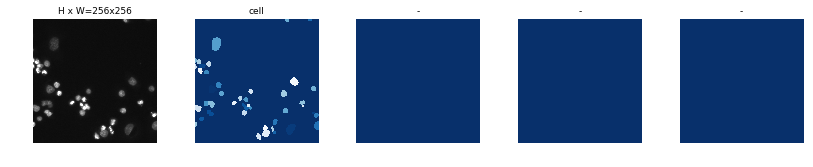

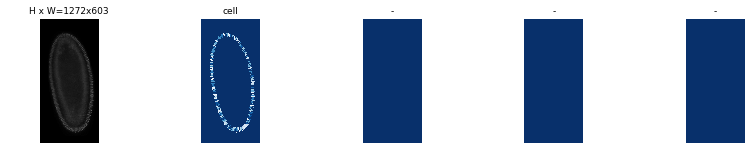

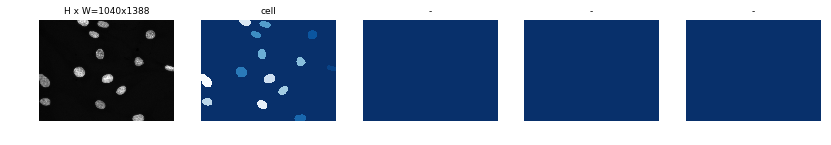

In [10]:
# Load and display random samples
image_ids = np.random.choice(dataset_train.image_ids, 4)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_train.class_names)

In [19]:
import skimage.io
import os
path = os.path.join(dataset_dir,"93c5638e7e6433b5c9cc87c152bcbe28873d2f9d6a392cca0642520807542a77", "images", "93c5638e7e6433b5c9cc87c152bcbe28873d2f9d6a392cca0642520807542a77.png")
image = skimage.io.imread(path)[:,:,3]
mask_dir = os.path.join(dataset_dir,"93c5638e7e6433b5c9cc87c152bcbe28873d2f9d6a392cca0642520807542a77", "masks")
mask = []
for mask_file in next(os.walk(mask_dir))[2]:
    mask.append(skimage.io.imread(os.path.join(mask_dir, mask_file)))
mask = np.array(mask, dtype=np.uint8)
mask &= 1
mask = np.stack(mask, axis=2)

In [20]:
import transform
image, mask = transform.horizontal_flip_transform2(image, mask)
#image, mask = transform.rotate90_transform2(image, mask, 180)

In [21]:
mask.shape

(256, 256)

In [15]:
mask.shape

(256, 256)

In [5]:
dataset_train._tmp_image

array([], shape=(224, 0, 3), dtype=uint8)

In [7]:
mask_count

[52,
 18,
 44,
 18,
 8,
 6,
 73,
 40,
 18,
 20,
 99,
 42,
 6,
 15,
 68,
 11,
 9,
 7,
 151,
 7,
 37,
 58,
 20,
 12,
 13,
 24,
 30,
 22,
 25,
 56,
 37,
 14,
 26,
 10,
 8,
 81,
 18,
 14,
 21,
 20,
 10,
 29,
 19,
 46,
 36,
 76,
 39,
 25,
 9,
 32,
 75,
 4,
 6,
 65,
 10,
 46,
 13,
 29,
 37,
 28,
 38,
 7,
 17,
 9,
 31,
 25,
 20,
 22,
 44,
 19,
 117,
 73,
 24,
 38,
 67,
 59,
 6,
 21,
 25,
 10,
 5,
 11,
 8,
 119,
 56,
 24,
 37,
 9,
 29,
 27,
 22,
 30,
 8,
 49,
 198,
 22,
 43,
 1,
 28,
 18,
 45,
 16,
 7,
 7,
 78,
 18,
 15,
 75,
 19,
 199,
 38,
 17,
 26,
 41,
 250,
 11,
 37,
 17,
 23,
 22,
 11,
 3,
 44,
 126,
 31,
 66,
 13,
 11,
 86,
 22,
 68,
 28,
 125,
 89,
 67,
 32,
 24,
 22,
 10,
 62,
 44,
 62,
 19,
 33,
 26,
 11,
 22,
 18,
 102,
 10,
 6,
 18,
 130,
 19,
 33,
 112,
 74,
 7,
 10,
 141,
 23,
 120,
 8,
 89,
 12,
 47,
 168,
 31,
 8,
 90,
 34,
 25,
 20,
 12,
 32,
 10,
 14,
 18,
 101,
 114,
 31,
 55,
 18,
 24,
 11,
 6,
 20,
 23,
 44,
 289,
 26,
 22,
 37,
 24,
 32,
 53,
 32,
 6,
 57,
 19,
 25,
 9,
 